In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import cv2

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.layers import ZeroPadding2D, Activation, Add

In [34]:
def make_dir(path):
  if not os.path.isdir(path):
    os.mkdir(path)

In [37]:
path_prefix = 'C:/HairData/hairs/'
model_prefix = 'C:/HairData/model/'

labels = ['YesHair', 'NoHair']

train_path = model_prefix + 'train'
valid_path = model_prefix + 'valid'
test_path = model_prefix + 'test'

make_dir(model_prefix)
make_dir(train_path)
make_dir(valid_path)
make_dir(test_path)

folder_list = [train_path, valid_path, test_path]

for folder_path in folder_list:
  for label in labels:
    temp_path = folder_path + '/' + label
    make_dir(temp_path)

In [38]:
import shutil

for label in labels:
  image_list = os.listdir(path_prefix + '/' + label)
  image_num = len(image_list)
  print(label + ' folder has ' + str(image_num) + ' images.')

  train_index = int(image_num)

  for image in image_list[:train_index]:
    shutil.copy(path_prefix + label + '/' + image, train_path + '/' + label + '/' + image)
  print("image moved")

YesHair folder has 375 images.
image moved
NoHair folder has 480 images.
image moved


In [43]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, 
                                   height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, 
                                   vertical_flip=True)
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), 
    batch_size=4, 
    class_mode='binary'
    )

Found 852 images belonging to 2 classes.


In [40]:
def Residual(x, model_info, index, filter, stride=1):
  shortcut = x

  if model_info[0] >= 50:
    for i in range(model_info[index]):
      if i == 0:            
        x = Conv2D(filter, (1, 1), strides=(stride, stride), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)        
            
        x = Conv2D(filter, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)  
 
        x = Conv2D(filter*4, (1, 1), strides=(1, 1), padding='valid')(x)
        shortcut = Conv2D(filter*4, (1, 1), strides=(stride, stride), padding='valid')(shortcut)
        x = BatchNormalization()(x)
        shortcut = BatchNormalization()(shortcut)            
 
        x = Add()([x, shortcut])    
        x = Activation('relu')(x)    
        shortcut = x
      
      else:
        x = Conv2D(filter, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
            
        x = Conv2D(filter, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
 
        x = Conv2D(filter * 4, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)            
 
        x = Add()([x, shortcut])     
        x = Activation('relu')(x)
        shortcut = x
   
  else:
    for i in range(model_info[index]):
      if i == 0:            
        x = Conv2D(filter, (3, 3), strides=(stride, stride), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)        
            
        x = Conv2D(filter, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)  

        shortcut = Conv2D(filter, (1, 1), strides=(stride, stride), padding='valid')(shortcut)
        x = BatchNormalization()(x)
        shortcut = BatchNormalization()(shortcut)            
 
        x = Add()([x, shortcut])    
        x = Activation('relu')(x)    
        shortcut = x
      
      else:
        x = Conv2D(filter, (1, 1), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
            
        x = Conv2D(filter, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = BatchNormalization()(x)            
 
        x = Add()([x, shortcut])     
        x = Activation('relu')(x)
        shortcut = x

  return x


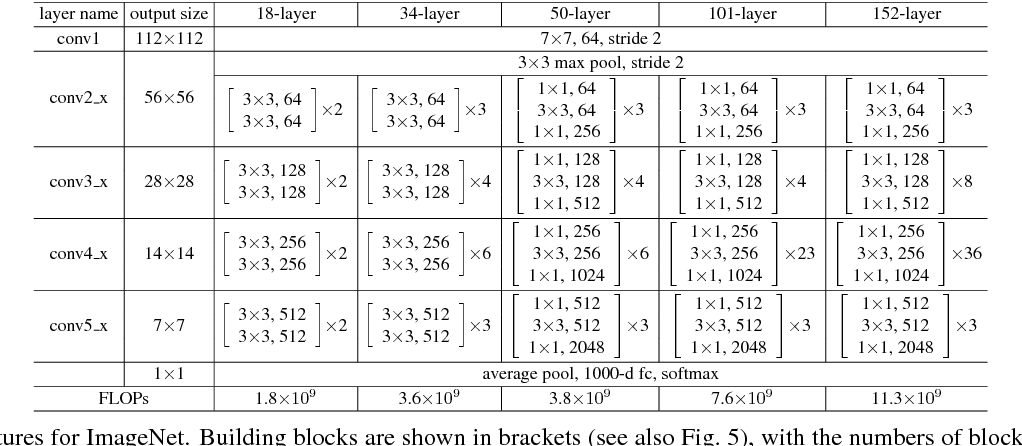

In [41]:
def ResNet(model_info):
  input = Input(shape=(224, 224, 3))
  x = ZeroPadding2D(padding=(3,3))(input)
  x = Conv2D(64, (7, 7), strides=(2,2))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = ZeroPadding2D(padding=(1,1))(x)

  x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)
  x = Residual(x, model_info, 1,  64)
  x = Residual(x, model_info, 2, 128, 2)
  x = Residual(x, model_info, 3, 256, 2)
  x = Residual(x, model_info, 4, 512, 2)

  x = GlobalAveragePooling2D()(x)
  output = Dense(1, activation='sigmoid')(x)  
  model = Model(input, output)
  return model

In [42]:
model_info = [[18, 2, 2, 2, 2], [34, 3, 4, 6, 3], [50, 3, 4, 6, 3], [101, 3, 4, 23, 3], [152, 3, 8, 36, 3]]

model = ResNet(model_info[4])
opt = Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [44]:
history = model.fit(
    train_generator, 
    steps_per_epoch = 852//4,
    epochs = 200,
)

Epoch 1/200
213/213 [==============================] - 76s 261ms/step - loss: 1.4564 - accuracy: 0.5435
Epoch 2/200
213/213 [==============================] - 56s 260ms/step - loss: 0.7595 - accuracy: 0.5517
Epoch 3/200
213/213 [==============================] - 56s 263ms/step - loss: 0.6928 - accuracy: 0.5822
Epoch 4/200
213/213 [==============================] - 56s 262ms/step - loss: 0.8001 - accuracy: 0.5414
Epoch 5/200
213/213 [==============================] - 56s 264ms/step - loss: 0.7140 - accuracy: 0.5303
Epoch 6/200
213/213 [==============================] - 56s 263ms/step - loss: 0.7150 - accuracy: 0.5518
Epoch 7/200
213/213 [==============================] - 55s 259ms/step - loss: 0.6889 - accuracy: 0.5733
Epoch 8/200
213/213 [==============================] - 56s 262ms/step - loss: 0.6948 - accuracy: 0.5793
Epoch 9/200
213/213 [==============================] - 55s 260ms/step - loss: 0.6483 - accuracy: 0.6468
Epoch 10/200
213/213 [==============================] - 55s 259m

213/213 [==============================] - 55s 259ms/step - loss: 0.4671 - accuracy: 0.7579
Epoch 80/200
213/213 [==============================] - 55s 260ms/step - loss: 0.4877 - accuracy: 0.7772
Epoch 81/200
213/213 [==============================] - 55s 260ms/step - loss: 0.4771 - accuracy: 0.7489
Epoch 82/200
213/213 [==============================] - 55s 260ms/step - loss: 0.4685 - accuracy: 0.7887
Epoch 83/200
213/213 [==============================] - 56s 262ms/step - loss: 0.4837 - accuracy: 0.7782
Epoch 84/200
213/213 [==============================] - 55s 259ms/step - loss: 0.4961 - accuracy: 0.7652
Epoch 85/200
213/213 [==============================] - 55s 260ms/step - loss: 0.4404 - accuracy: 0.7894
Epoch 86/200
213/213 [==============================] - 55s 258ms/step - loss: 0.4861 - accuracy: 0.7605
Epoch 87/200
213/213 [==============================] - 55s 259ms/step - loss: 0.4961 - accuracy: 0.7415
Epoch 88/200
213/213 [==============================] - 55s 259ms/st

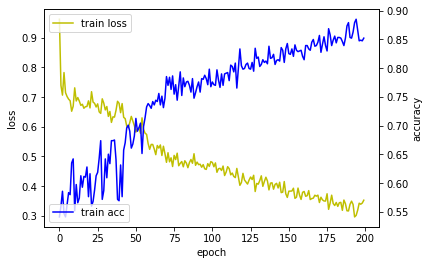

In [45]:
#모델 세이브 꼭 해야해!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save('hair_model.h5')

fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

In [38]:
scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

C:\Users\qnfpd\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  0.3422949016094208 
Total Accuracy :  0.854651153087616


In [17]:
#안드로이드에 넣기위한 작업 h5->pb
from tensorflow import keras
model = keras.models.load_model('C:/HairData/hair_model.h5', compile=False)
 
export_path = 'C:/HairData/pb'
model.save(export_path, save_format="tf")

INFO:tensorflow:Assets written to: C:/HairData/pb\assets


In [18]:
#pb->tflite
import tensorflow as tf
saved_model_dir = 'C:/HairData/pb/'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
open('C:/HairData/pb_to_tflite/converted_model.tflite', 'wb').write(tflite_model)

232341444

In [2]:
#기존에 학습시킨 모델을 불러옵니다
from tensorflow.keras.models import load_model
model=load_model('C:/HairData/hair_model.h5')

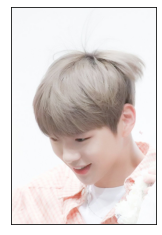

[[0.637372]]
잠재적 탈모


In [9]:
#단일 이미지를 prediction하는 코드입니다
#img = cv2.imread('C:/HairData/3709.jpg')
img = cv2.imread('C:/HairData/hairs/YesHair/format86_2.jpg')
b,g,r = cv2.split(img)
img2 = cv2.merge([r,g,b])
plt.imshow(img2)
plt.xticks([])
plt.yticks([])
plt.show()
img = cv2.resize(img2, (224, 224))
#img = img[np.newaxis,:,:]
img = img.astype("float") / 255.0
img = np.array(img)
img = np.expand_dims(img, axis=0)
print(model.predict(img))
prediction = model.predict(img)[0]
idx = np.round(prediction)
if(idx == 0):
    print('탈모')
elif(idx == 1):
    print('잠재적 탈모')